# GoogleDriveをマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
os.chdir("./drive/My Drive/202009_Bayesian_Network/")

## プログラム実行前の設定など

In [3]:
# 乱数のシードを設定
import random
import numpy as np

np.random.seed(1234)
random.seed(1234)


In [12]:
# 使用するパッケージ（ライブラリと関数）を定義
#独立性の検定に使用
from pgmpy.estimators import ConstraintBasedEstimator

#組み合わせを取得する関数
import itertools

# その他
import pandas as pd
from IPython.display import Image

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## データの作成

In [13]:
#タイタニックデータ読み込み
df = pd.read_csv('titanic.csv')

#不要な列・欠損が多い列を削除
df = df.drop('PassengerId',axis=1).drop('Name',axis=1).drop('Ticket',axis=1).drop('Cabin',axis=1)

df['Age'] = df['Age'].fillna(df['Age'].mean())

df['Age'] = pd.cut(df['Age'],3)
df['Fare'] = pd.cut(df['Fare'],3)

df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [14]:
df.shape

(891, 8)

In [15]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,"(0.34, 26.947]",1,0,"(-0.512, 170.776]",S
1,1,1,female,"(26.947, 53.473]",1,0,"(-0.512, 170.776]",C
2,1,3,female,"(0.34, 26.947]",0,0,"(-0.512, 170.776]",S
3,1,1,female,"(26.947, 53.473]",1,0,"(-0.512, 170.776]",S
4,0,3,male,"(26.947, 53.473]",0,0,"(-0.512, 170.776]",S


## PCアルゴリズムを実施

## pgmpy（Python library for Probabilistic Graphical Models）によるPCアルゴリズム

In [17]:
!pip install pgmpy==0.1.9

## 0次の独立性

In [18]:
#0次の独立性を検定する関数定義
def independence_0(df):
  independence_list=[]
  est = ConstraintBasedEstimator(df)
  for col1,col2 in list(itertools.combinations(df.columns, 2)):
    result = est.test_conditional_independence(col1, col2, method="chi_square", tol=0.01)
    print("{}-{} -> {}".format(col1,col2,result))
    if not result:
      independence_list.append([col1,col2]) 
  return independence_list

In [19]:
#0次の独立性検定の実行
independence_list_0 = independence_0(df)

Survived-Pclass -> False
Survived-Sex -> False
Survived-Age -> True
Survived-SibSp -> False
Survived-Parch -> False
Survived-Fare -> True
Survived-Embarked -> False
Pclass-Sex -> False
Pclass-Age -> False
Pclass-SibSp -> False
Pclass-Parch -> True
Pclass-Fare -> False
Pclass-Embarked -> False
Sex-Age -> True
Sex-SibSp -> False
Sex-Parch -> False
Sex-Fare -> True
Sex-Embarked -> True
Age-SibSp -> False
Age-Parch -> False
Age-Fare -> True
Age-Embarked -> True
SibSp-Parch -> False
SibSp-Fare -> True
SibSp-Embarked -> True
Parch-Fare -> True
Parch-Embarked -> True
Fare-Embarked -> False


In [20]:
#0次の独立性の検定結果、独立ではなかったものを列挙
independence_list_0

[['Survived', 'Pclass'],
 ['Survived', 'Sex'],
 ['Survived', 'SibSp'],
 ['Survived', 'Parch'],
 ['Survived', 'Embarked'],
 ['Pclass', 'Sex'],
 ['Pclass', 'Age'],
 ['Pclass', 'SibSp'],
 ['Pclass', 'Fare'],
 ['Pclass', 'Embarked'],
 ['Sex', 'SibSp'],
 ['Sex', 'Parch'],
 ['Age', 'SibSp'],
 ['Age', 'Parch'],
 ['SibSp', 'Parch'],
 ['Fare', 'Embarked']]

## 1次の独立性

In [21]:
#1次の独立性を検定する関数定義
def independence_1(independence_list_0,base_col):
  est = ConstraintBasedEstimator(df)
  #base_colを含むindependence_list_0
  check_lists = [li for li in independence_list_0 if base_col in li]
  print('check_lists={}'.format(check_lists))

  #関連が1つのみの場合は処理をスキップ
  if len(check_lists) <= 1:
    print('関連が1つのため{}はスキップ'.format(base_col))
    return independence_list_0
    

  #base_colとの条件付き確率を計算する列リスト
  check_cols = list(itertools.chain.from_iterable(check_lists))
  while True:
    try :
      check_cols.remove(base_col)
    except :break
  
  for check_list in check_lists:
    rm_flg = 1
    print("="*30)
    print('checking...{}'.format(check_list))
    #targetcolとの独立性を確認する説明変数1つ
    check_col = list(filter(lambda x: x != base_col, check_list))[0]
    #条件付き確率の条件となる説明変数リスト
    conditional_cols = list(filter(lambda x: x != check_col, check_cols))

    #条件付き独立の判定
    for conditional_col in conditional_cols:
      result = est.test_conditional_independence(base_col, check_col, [conditional_col], method="chi_square", tol=0.01)
      print("{}-{} | {} -> {}".format(base_col,check_col,conditional_col,result))
      if result and rm_flg:
        rm_flg = 0
        independence_list_0.remove(check_list) 
    if not rm_flg:print('★delete {}'.format(check_list))
  return independence_list_0

In [22]:
#1次の独立性検定の実行
for base_col in df.columns:
  print('●'*30)
  print('base_col={}'.format(base_col))
  independence_list_1 = independence_1(independence_list_0,base_col)

●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●
base_col=Survived
check_lists=[['Survived', 'Pclass'], ['Survived', 'Sex'], ['Survived', 'SibSp'], ['Survived', 'Parch'], ['Survived', 'Embarked']]
checking...['Survived', 'Pclass']
Survived-Pclass | Sex -> False
Survived-Pclass | SibSp -> False
Survived-Pclass | Parch -> False
Survived-Pclass | Embarked -> False
checking...['Survived', 'Sex']
Survived-Sex | Pclass -> False
Survived-Sex | SibSp -> False
Survived-Sex | Parch -> False
Survived-Sex | Embarked -> False
checking...['Survived', 'SibSp']
Survived-SibSp | Pclass -> True
Survived-SibSp | Sex -> True
Survived-SibSp | Parch -> False
Survived-SibSp | Embarked -> True
★delete ['Survived', 'SibSp']
checking...['Survived', 'Parch']
Survived-Parch | Pclass -> True
Survived-Parch | Sex -> True
Survived-Parch | SibSp -> False
Survived-Parch | Embarked -> True
★delete ['Survived', 'Parch']
checking...['Survived', 'Embarked']
Survived-Embarked | Pclass -> True
Survived-Embarked | Sex -> True
Survived-Embarke

In [23]:
#1次の独立性の検定結果、独立ではなかったものを列挙
independence_list_1

[['Survived', 'Pclass'],
 ['Survived', 'Sex'],
 ['Pclass', 'Age'],
 ['Pclass', 'Fare'],
 ['Pclass', 'Embarked'],
 ['Sex', 'Parch'],
 ['SibSp', 'Parch']]

## 2次の独立性

In [24]:
#2次の独立性を検定する関数定義
def independence_2(independence_list_1,base_col):
  est = ConstraintBasedEstimator(df)
  #base_colを含むindependence_list_1
  check_lists = [li for li in independence_list_1 if base_col in li]
  print('check_lists={}'.format(check_lists))

  #関連が2つ以下の場合は処理をスキップ(2変数を条件とした条件付き確率を設定するためには4変数(=3関連)が必要)
  if len(check_lists) <= 2:
    print('関連が2つ以下のため{}はスキップ'.format(base_col))
    return independence_list_1

  #base_colとの条件付き確率を計算する列リスト
  check_cols = list(itertools.chain.from_iterable(check_lists))
  while True:
    try :
      check_cols.remove(base_col)
    except :break
  
  for check_list in check_lists:
    rm_flg = 1
    print("="*30)
    print('checking...{}'.format(check_list))
    #targetcolとの独立性を確認する説明変数1つ
    check_col = list(filter(lambda x: x != base_col, check_list))[0]
    #条件付き確率の条件となる説明変数リスト
    _conditional_cols = list(filter(lambda x: x != check_col, check_cols))
    #2次の独立なので、1次の独立とは違い、1変数ずつではなく2変数の組み合わせを取得する
    conditional_cols = list(itertools.combinations(_conditional_cols, 2))

    #条件付き独立の判定
    for conditional_col in conditional_cols:
      print('conditional_col={}'.format(conditional_col))
      result = est.test_conditional_independence(base_col, check_col, list(conditional_col), method="chi_square", tol=0.01)
      print("{}-{} | {} -> {}".format(base_col,check_col,conditional_col,result))
      if result and rm_flg:
        rm_flg = 0
        independence_list_1.remove(check_list) 
    if not rm_flg:print('★delete {}'.format(check_list))
  return independence_list_1

In [25]:
#2次の独立性検定の実行
for base_col in df.columns:
  print('●'*30)
  print('base_col={}'.format(base_col))
  independence_list_2 = independence_2(independence_list_1,base_col)

●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●
base_col=Survived
check_lists=[['Survived', 'Pclass'], ['Survived', 'Sex']]
関連が2つ以下のためSurvivedはスキップ
●●●●●●●●●●●●●●●●●●●●●●●●●●●●●●
base_col=Pclass
check_lists=[['Survived', 'Pclass'], ['Pclass', 'Age'], ['Pclass', 'Fare'], ['Pclass', 'Embarked']]
checking...['Survived', 'Pclass']
conditional_col=('Age', 'Fare')
Pclass-Survived | ('Age', 'Fare') -> False
conditional_col=('Age', 'Embarked')
Pclass-Survived | ('Age', 'Embarked') -> False
conditional_col=('Fare', 'Embarked')
Pclass-Survived | ('Fare', 'Embarked') -> False
checking...['Pclass', 'Age']
conditional_col=('Survived', 'Fare')
Pclass-Age | ('Survived', 'Fare') -> False
conditional_col=('Survived', 'Embarked')
Pclass-Age | ('Survived', 'Embarked') -> False
conditional_col=('Fare', 'Embarked')
Pclass-Age | ('Fare', 'Embarked') -> False
checking...['Pclass', 'Fare']
conditional_col=('Survived', 'Age')
Pclass-Fare | ('Survived', 'Age') -> False
conditional_col=('Survived', 'Embarked')
Pclass-Fare | ('Su

In [26]:
#2次の独立性の検定結果、独立ではなかったものを列挙
independence_list_2

[['Survived', 'Pclass'],
 ['Survived', 'Sex'],
 ['Pclass', 'Age'],
 ['Pclass', 'Embarked'],
 ['Sex', 'Parch'],
 ['SibSp', 'Parch']]

## スケルトンの可視化

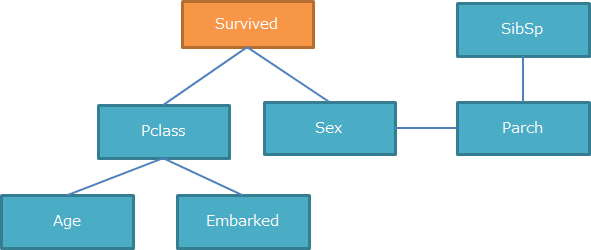

In [37]:
Image("skeleton.png")

## V-structureの探索

In [40]:
# V-structureの探索(条件付き非独立の場合、連結できる)
#①Pclass-Survived-Sex
print(est.test_conditional_independence(
    'Pclass', 'Sex', ['Survived'], method="chi_square", tol=0.01))

#②Age-Pclass-Embarked
print(est.test_conditional_independence(
    'Age', 'Embarked', ['Pclass'], method="chi_square", tol=0.01))

#③Survived-Sex-Parch
print(est.test_conditional_independence(
    'Survived', 'Parch', ['Sex'], method="chi_square", tol=0.01))

#④Sex-Parch-SibSp
print(est.test_conditional_independence(
    'Sex', 'SibSp', ['Parch'], method="chi_square", tol=0.01))

#①Pclass-Survived-SexのみFalse(独立ではない(=関連がある))となる。

False
True
True
True


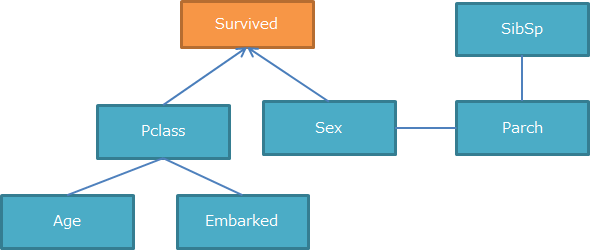

In [50]:
Image("V-structure.png")

## オリエンテーションルールを適用しても結果は変わらず。

## 残りの無向グラフの方向を決定

In [46]:
#無向グラフ部分に対して、全パターンの有向グラフを仮定し、それぞれに対してBICを算出
#最もBICの絶対値が大きいものを最終的なアウトプットとする
from pgmpy.models import BayesianModel
from pgmpy.estimators import BicScore

model = BayesianModel([('Pclass', 'Survived'), ('Sex', 'Survived'),('Pclass', 'Age'), ('Pclass', 'Embarked'),('Sex', 'Parch'), ('Parch', 'SibSp')])  
print(BicScore(df).score(model))

model = BayesianModel([('Pclass', 'Survived'), ('Sex', 'Survived'),('Pclass', 'Age'), ('Pclass', 'Embarked'),('Sex', 'Parch'), ('SibSp', 'Parch')])  
print(BicScore(df).score(model))

model = BayesianModel([('Pclass', 'Survived'), ('Sex', 'Survived'),('Pclass', 'Age'), ('Pclass', 'Embarked'),('Parch', 'Sex'), ('Parch', 'SibSp')])  
print(BicScore(df).score(model))

model = BayesianModel([('Pclass', 'Survived'), ('Sex', 'Survived'),('Pclass', 'Age'), ('Pclass', 'Embarked'),('Parch', 'Sex'), ('SibSp', 'Parch')])  
print(BicScore(df).score(model))

model = BayesianModel([('Pclass', 'Survived'), ('Sex', 'Survived'),('Pclass', 'Age'), ('Embarked', 'Pclass'),('Sex', 'Parch'), ('Parch', 'SibSp')])  
print(BicScore(df).score(model))

model = BayesianModel([('Pclass', 'Survived'), ('Sex', 'Survived'),('Pclass', 'Age'), ('Embarked', 'Pclass'),('Sex', 'Parch'), ('SibSp', 'Parch')])  
print(BicScore(df).score(model))

model = BayesianModel([('Pclass', 'Survived'), ('Sex', 'Survived'),('Pclass', 'Age'), ('Embarked', 'Pclass'),('Parch', 'Sex'), ('Parch', 'SibSp')])  
print(BicScore(df).score(model))

model = BayesianModel([('Pclass', 'Survived'), ('Sex', 'Survived'),('Pclass', 'Age'), ('Embarked', 'Pclass'),('Parch', 'Sex'), ('SibSp', 'Parch')])  
print(BicScore(df).score(model))

model = BayesianModel([('Pclass', 'Survived'), ('Sex', 'Survived'),('Age', 'Pclass'), ('Pclass', 'Embarked'),('Sex', 'Parch'), ('Parch', 'SibSp')])  
print(BicScore(df).score(model))

model = BayesianModel([('Pclass', 'Survived'), ('Sex', 'Survived'),('Age', 'Pclass'), ('Pclass', 'Embarked'),('Sex', 'Parch'), ('SibSp', 'Parch')])  
print(BicScore(df).score(model))

model = BayesianModel([('Pclass', 'Survived'), ('Sex', 'Survived'),('Age', 'Pclass'), ('Pclass', 'Embarked'),('Parch', 'Sex'), ('Parch', 'SibSp')])  
print(BicScore(df).score(model))

model = BayesianModel([('Pclass', 'Survived'), ('Sex', 'Survived'),('Age', 'Pclass'), ('Pclass', 'Embarked'),('Parch', 'Sex'), ('SibSp', 'Parch')])  
print(BicScore(df).score(model))

model = BayesianModel([('Pclass', 'Survived'), ('Sex', 'Survived'),('Age', 'Pclass'), ('Embarked', 'Pclass'),('Sex', 'Parch'), ('Parch', 'SibSp')])  
print(BicScore(df).score(model))

#########最も良いモデル(BICの絶対値が最大)
model = BayesianModel([('Pclass', 'Survived'), ('Sex', 'Survived'),('Age', 'Pclass'), ('Embarked', 'Pclass'),('Sex', 'Parch'), ('SibSp', 'Parch')])  
print(BicScore(df).score(model))
#########

model = BayesianModel([('Pclass', 'Survived'), ('Sex', 'Survived'),('Age', 'Pclass'), ('Embarked', 'Pclass'),('Parch', 'Sex'), ('Parch', 'SibSp')])  
print(BicScore(df).score(model))

model = BayesianModel([('Pclass', 'Survived'), ('Sex', 'Survived'),('Age', 'Pclass'), ('Embarked', 'Pclass'),('Parch', 'Sex'), ('SibSp', 'Parch')])  
print(BicScore(df).score(model))

-4810.31791974438
-4917.67249859442
-4810.31791974438
-4810.317919744381
-4810.31791974438
-4917.67249859442
-4810.31791974438
-4810.317919744381
-4810.31791974438
-4917.67249859442
-4810.31791974438
-4810.31791974438
-4829.55707321401
-4936.911652064051
-4829.55707321401
-4829.55707321401


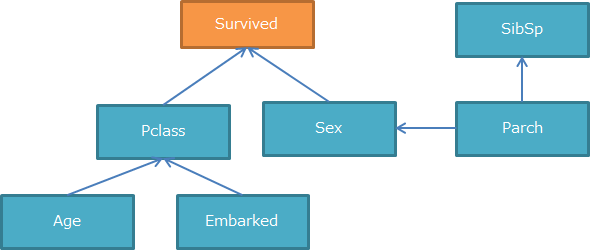

In [49]:
Image("BIC.png")

# おまけ

## pgmpyでPCアルゴリズムの実行

In [32]:
est = ConstraintBasedEstimator(df)

skel, seperating_sets = est.estimate_skeleton(significance_level=0.01)
print("Undirected edges: ", skel.edges())

pdag = est.skeleton_to_pdag(skel, seperating_sets)
print("PDAG edges:       ", pdag.edges())

model = est.pdag_to_dag(pdag)
print("DAG edges:        ", model.edges())


Undirected edges:  [('Survived', 'Pclass'), ('Survived', 'Sex'), ('Pclass', 'Age'), ('Pclass', 'Embarked'), ('Sex', 'Parch'), ('SibSp', 'Parch')]
PDAG edges:        [('Age', 'Pclass'), ('SibSp', 'Parch'), ('Parch', 'Sex'), ('Parch', 'SibSp'), ('Embarked', 'Pclass')]
DAG edges:         [('Age', 'Pclass'), ('Parch', 'Sex'), ('Parch', 'SibSp'), ('Embarked', 'Pclass')]


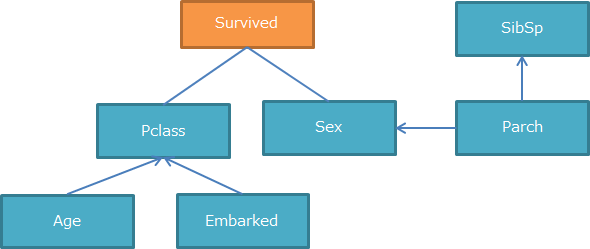

In [48]:
#目的変数「Survived」周り以外は全て一致した
Image("pgmpy.png")

In [53]:
#試しにBICを算出
model = BayesianModel([('Age', 'Pclass'), ('Embarked', 'Pclass'),('Sex', 'Parch'), ('SibSp', 'Parch')])  
print(BicScore(df).score(model))

#BICの絶対値が小さいので、「Survived」への矢印はあった方が良い

-4517.5517518749075
